In [34]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image

In [35]:
import camb
import numpy as np
import pandas as pd
import sqlite3
import scipy as sp
import scipy.integrate
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from camb import model, initialpower
from astropy.table import Table
from scipy.misc import derivative

# Go through notebook and compare Ross method at every step

## Things I have changed: 

- Make Chi interperlation function go to higher z - Ross goes 0 to 2, I went 0 - 1 in z
- require binning to be in .1 sections like ross, do it my way and get weird bins, see below
- Changed interpolation to k = 5

In [36]:
h = .6774

In [37]:
# a = 1/(1+z)
def hubble_z(z): # Flat universe: omega_k = 0
    hubble_0 = 67.74 # km/sec/Mpc
    Omega_m = .3089
    Omega_L = .6911
    H_z = np.sqrt((hubble_0**2)*(Omega_m*(1 + z)**3 + Omega_L))
    return H_z

hubble_z(2.0)

203.57419733021177

In [38]:
def hubble_z_ROSS(a):
    H0=100
    om=0.3089
    ol=1.-om
    result=H0*((om/(1.*a**3))+ol)**0.5
    return result

a = 1.0 / (1.0 + 2.0)
hubble_z_ROSS(a)

300.5228776649126

In [39]:
def chi_z(z_max):
    c = 3.0*(10**5) # km/sec 
    integrand = lambda z: c / hubble_z(z)
    chi_z = scipy.integrate.quad(integrand, 0, z_max)
    return chi_z[0]

chi_z(2.0)

5316.055934317975

In [40]:
def chi_z_ROSS(z):
    athen=1/(1+z)
    c=3.*10**5
    chiint=scipy.integrate.quad(lambda a: 1/((a**2)*hubble_z_ROSS(a)), athen, 1)
    result=c*chiint[0]
    return result

chi_z_ROSS(2.0)/h

5316.055934317976

### hubble_z and chi_z agree with Ross except for H discrepencies

In [41]:
z_values = np.linspace(0, 2, 100)
chi_values = [chi_z(redShift) for redShift in z_values]

z_chi_interp = InterpolatedUnivariateSpline(chi_values, z_values, k=5)

def z_chi(chi):
    z_val = z_chi_interp(chi)
    return z_val

#check with ned wright site
print(z_chi(100/h))
print(z_chi(1000/h))
print(z_chi(1317/h))
print(z_chi(1945/h))  
print(z_chi(2871/h))

0.03359654087352638
0.36557790249865124
0.4991677132128099
0.8005337261309441
1.3746073586234786


In [42]:
zs201=np.arange(201)*0.01
chiarray=np.zeros(201)
for i in range(0,201):
    chiarray[i]=chi_z_ROSS(zs201[i])

zchiinterp=sp.interpolate.InterpolatedUnivariateSpline(chiarray,zs201,k=5)

h=0.6774
def z_chi_ROSS(chi):
    result=zchiinterp(chi)
    return result

#check with ned wright site
print(z_chi_ROSS(100))
print(z_chi_ROSS(1000))
print(z_chi_ROSS(1317))  #my chis are true chi*h....so this is 1945 real mpc
print(z_chi_ROSS(1945))  #this is 2871 real mpc
print(z_chi_ROSS(2871))

0.03359654087434861
0.36557790249865
0.4991677132128007
0.800533726130937
1.3746073586234788


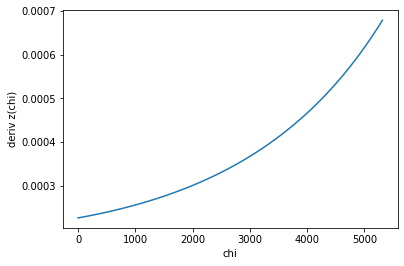

In [43]:
z_chi_deriv = z_chi_interp.derivative()

z_chi_deriv_vals = [z_chi_deriv(chi) for chi in chi_values]

plt.plot(chi_values, z_chi_deriv_vals)
plt.xlabel('chi')
plt.ylabel('deriv z(chi)')
plt.show()

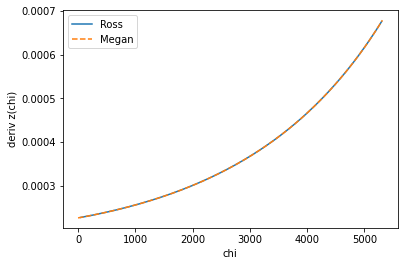

In [44]:
derivarray=np.zeros(201)
for j in range(0,201):
    derivarray[j]=derivative(z_chi_ROSS,chiarray[j])

#print (chiarray)
#print (derivarray)
plt.plot(chiarray[1:200]/h,derivarray[1:200]*h, label="Ross")
plt.plot(chi_values, z_chi_deriv_vals, linestyle="--", label="Megan")
plt.xlabel('chi')
plt.ylabel('deriv z(chi)')
plt.legend()
plt.show()

### z_chi_deriv and derivarray match exactly

In [45]:
CMASSLOWZTOT_South_Tbl = Table.read('/Users/megantabbutt/CosmologyDataProducts/' 
                                    + 'galaxy_DR12v5_CMASSLOWZTOT_South.fits', format='fits')
del CMASSLOWZTOT_South_Tbl['FRACPSF', 'EXPFLUX', 'DEVFLUX', 'PSFFLUX', 'MODELFLUX', 'FIBER2FLUX', 'R_DEV', 'EXTINCTION', 
                           'PSF_FWHM', 'SKYFLUX', 'IMAGE_DEPTH', 'TILE', 'RERUN', 'CAMCOL', 'FIELD', 'ID', 'ICHUNK', 'RUN', 
                          'IPOLY', 'AIRMASS', 'EB_MINUS_V', 'IMATCH', 'WEIGHT_FKP', 'WEIGHT_CP', 'WEIGHT_NOZ', 'WEIGHT_STAR',
                          'WEIGHT_SEEING', 'WEIGHT_SYSTOT', 'COMP', 'PLATE', 'FIBERID', 'MJD', 'FINALN', 'SPECTILE', 'ICOLLIDED', 
                          'INGROUP', 'MULTGROUP', 'ISECT']
CMASSLOWZTOT_DF = CMASSLOWZTOT_South_Tbl.to_pandas()
CMASSLOWZTOT_DF.head(3)


,RA,DEC,Z,NZ
0,321.480329,9.973440,0.301401,0.000390
1,321.359691,9.933358,0.458872,0.000350
2,322.614181,10.144496,0.579383,0.000273


In [46]:
"""connBOSS = sqlite3.connect('/Users/megantabbutt/CosmologyDataProducts/' + 'CMASS_and_LOWZ.db')
CMASSLOWZTOT_DF = pd.read_sql("SELECT * FROM CMASSLOWZTOT_South", con=connBOSS)
connBOSS.close()
CMASSLOWZTOT_DF.head(3) # 1.3 million objects"""

'connBOSS = sqlite3.connect(\'/Users/megantabbutt/CosmologyDataProducts/\' + \'CMASS_and_LOWZ.db\')\nCMASSLOWZTOT_DF = pd.read_sql("SELECT * FROM CMASSLOWZTOT_South", con=connBOSS)\nconnBOSS.close()\nCMASSLOWZTOT_DF.head(3) # 1.3 million objects'

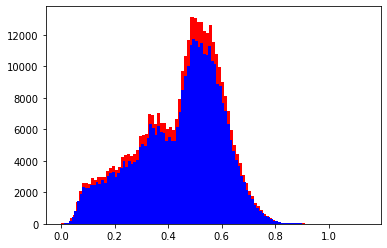

In [47]:
# Megan binning: 

bin_num = 101

# Force bins to be same width
bins=np.arange(bin_num)*0.01+0.
bins

a = plt.hist(CMASSLOWZTOT_DF['Z'], bins=bin_num, color='r')
c = plt.hist(CMASSLOWZTOT_DF['Z'], bins=bins, color='b')
plt.show()

In [48]:
print(a[1][0:10])
print(c[1][0:10])

[-0.00037981  0.01087728  0.02213436  0.03339145  0.04464854  0.05590562
  0.06716271  0.07841979  0.08967688  0.10093396]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


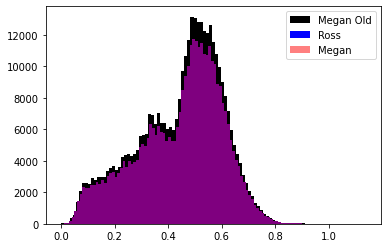

In [49]:
# Ross Binning: 

zs1=np.arange(101)*0.01+0.
zs=np.arange(100)*0.01+0.005
plt.hist(CMASSLOWZTOT_DF['Z'], bins=bin_num, color='k', label="Megan Old")
b=plt.hist(CMASSLOWZTOT_DF['Z'], bins=zs1, color='b', label="Ross")
plt.hist(CMASSLOWZTOT_DF['Z'], bins=bins, color='r', label="Megan", alpha=.5)
pz=b[0]
pz=pz*100/np.sum(b[0])
plt.legend()
plt.show()

normal (1.0001082842865217, 4.630657846275047e-08)


<ipython-input-50-1450e6d6b04c>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  normal=scipy.integrate.quad(lambda z: W2(z),0.0,1.0)


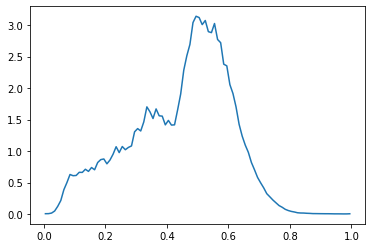

In [50]:
W2 = sp.interpolate.InterpolatedUnivariateSpline(zs,pz,k=5)

w2array=np.zeros(len(zs))
for j in range(0,len(w2array)):
    w2array[j]=W2(zs[j])

plt.plot(zs,w2array)
normal=scipy.integrate.quad(lambda z: W2(z),0.0,1.0)
print ('normal', normal)
plt.show()

In [55]:
c[0]
bin_centers = [i + .005 for i in c[1][:-1]]

n_norm = c[0]*100/sum(c[0])

n_interp = interpolate.interp1d(bin_centers, n_norm, kind='cubic', bounds_error=False, fill_value=0.0)  
#n_interp = sp.interpolate.InterpolatedUnivariateSpline(bin_centers, n_norm, k=5)

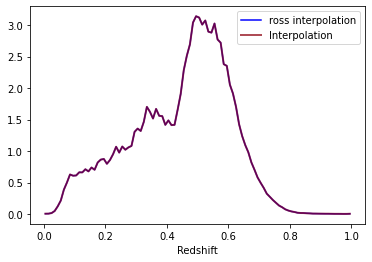

In [56]:
plt.plot(zs,w2array, c="b", label="ross interpolation")
plt.plot(bin_centers, n_interp(bin_centers), label="Interpolation", c="#8c000f", alpha=.7, lw=2)
plt.xlabel("Redshift")
plt.legend()
plt.show()

### n_interp and W2 agree

(0.9999537971940086, 1.3369615988593272e-08)


<ipython-input-57-869145dfc04f>:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = scipy.integrate.quad(integrand, limit_min, limit_max, epsrel=10**-12, epsabs=10**-12, limit=5000)


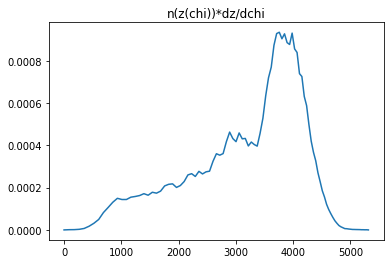

In [57]:
def quad_one_dim(integrand, limit_min, limit_max):
    integral = scipy.integrate.quad(integrand, limit_min, limit_max, epsrel=10**-12, epsabs=10**-12, limit=5000)  
    return integral

# n(z) dz/dx integral over x
normalization = quad_one_dim((lambda x: n_interp(z_chi(x)) * z_chi_deriv(x)), chi_z(0.0), chi_z(1.0))
print(normalization)

intgrand = [(n_interp(z_chi(x)) * z_chi_deriv(x)) for x in np.linspace(chi_z(0.0), chi_z(1.0), 100)]

plt.plot(chi_values, intgrand)
plt.title('n(z(chi))*dz/dchi')
plt.show()

### We still agree here

Note: redshifts have been re-sorted (earliest first)


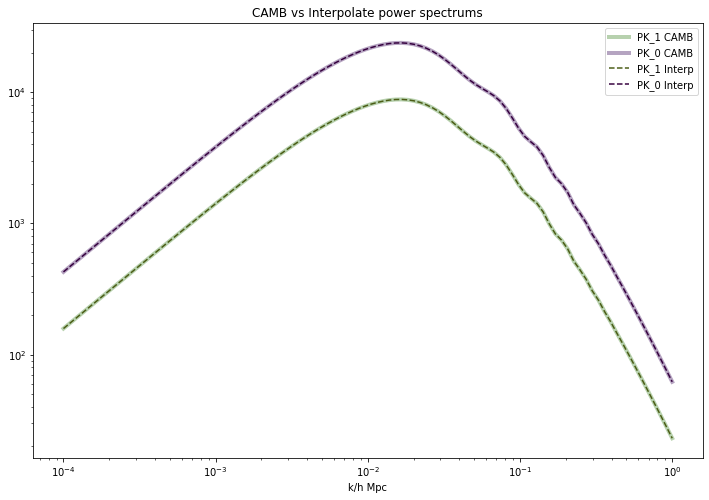

k = .001, .5 [253.28519434]
[1574.52303458]
[10557.29609683]
[5553.99820116]


In [58]:
ombh2=0.0225
omch2=0.1188
ns=.96

#Now get matter power spectra at redshift 0 and 1.0
params = camb.CAMBparams()
params.set_cosmology(H0=67.74, ombh2=ombh2, omch2=omch2)
params.InitPower.set_params(ns=ns)

#Note non-linear corrections couples to smaller scales than you want
params.set_matter_power(redshifts=np.linspace(0.0, 1.0, num = 100), kmax=2.0)

#Linear spectra
params.NonLinear = model.NonLinear_none
results = camb.get_results(params)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 100)

matter_power_spectrum = interpolate.interp2d(kh, z, pk, kind='quintic')

# Plot the matter power spectrum from CAMB and the interpolation
plt.figure(figsize=(12, 8))
kh_list = np.logspace(-4.0, 0, num=100)
z_list = np.linspace(min(z), max(z), num=100)

plt.loglog(kh, pk[-1,:], color='#88b378', ls = "-", label="PK_1 CAMB", linewidth=4, alpha=.6)
plt.loglog(kh, pk[0,:], color='#856798', ls = "-", label="PK_0 CAMB", linewidth=4, alpha=.6)

plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[-1,:], color='#4b5d16', ls = "--", label="PK_1 Interp")
plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[0,:], color='#36013f', ls = "--", label="PK_0 Interp")

plt.xlabel('k/h Mpc')
#plt.xlim(11**-4, 2)
plt.legend(loc = "upper right")
plt.title("CAMB vs Interpolate power spectrums")
plt.show()

print("k = .001, .5", matter_power_spectrum(.0001*h, .5))
print(matter_power_spectrum(.001*h, .5))
print(matter_power_spectrum(.01*h, .5))
print(matter_power_spectrum(.1*h, .5))

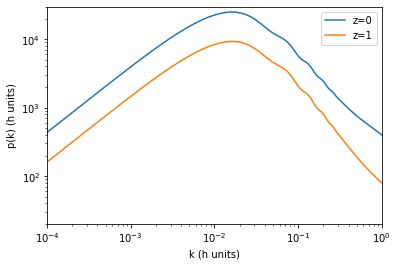

[[258.01503733]]
[[2344.81075925]]
[[13394.53395052]]
[[3341.01598793]]


In [59]:
pkall=np.genfromtxt('/Users/megantabbutt/CosmologyDataProducts/pk_none_z0-7_k200cosmosis_kmax100_2019.txt')
newpk=np.reshape(pkall,((701,200)))
klist=np.genfromtxt('/Users/megantabbutt/CosmologyDataProducts/k_h_planck2015ext.txt')
kmin=np.min(klist)
kmax=np.max(klist)
zlist=np.arange(701)*0.01
Pk = sp.interpolate.RectBivariateSpline(zlist,klist,newpk,kx=5,ky=5)

def newPk3(k,z):
    result=Pk(z,k)
    return result

plt.plot(klist,newpk[0],label='z=0')
plt.plot(klist,newpk[100],label='z=1')
plt.xlabel('k (h units)')
plt.ylabel('p(k) (h units)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**-4,1)
plt.ylim(2*10,3*10**4)
plt.legend()
plt.show()

print(newPk3(.0001, .5))
print(newPk3(.001, .5))
print(newPk3(.01, .5))
print(newPk3(.1, .5))

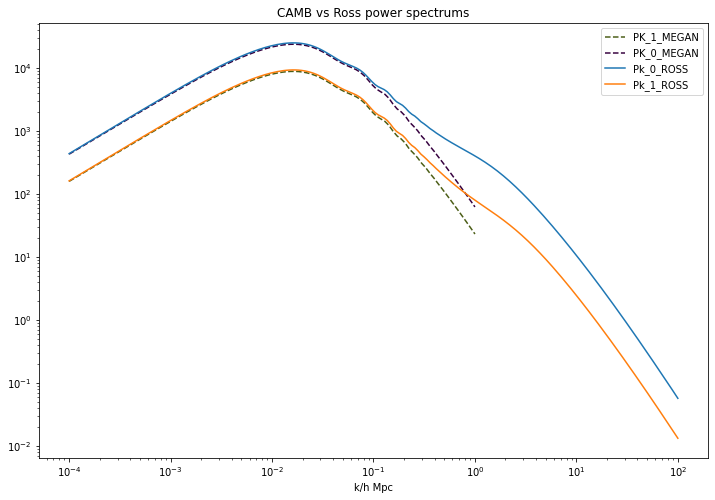

In [60]:
# Plot the matter power spectrum from CAMB and the interpolation
plt.figure(figsize=(12, 8))
kh_list = np.logspace(-4.0, 0, num=100)
z_list = np.linspace(min(z), max(z), num=100)

plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[-1,:], color='#4b5d16', ls = "--", label="PK_1_MEGAN")
plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[0,:], color='#36013f', ls = "--", label="PK_0_MEGAN")

plt.loglog(klist,newpk[0],label='Pk_0_ROSS')
plt.loglog(klist,newpk[100],label='Pk_1_ROSS')

plt.xlabel('k/h Mpc')
#plt.xlim(11**-4, 2)
plt.legend(loc = "upper right")
plt.title("CAMB vs Ross power spectrums")
plt.show()

### Matter power spectrum deviate at .1 ish - ask Ross what his data is from, more right?

In [61]:
def j0(arg):
    return scipy.special.jv(0, arg)

"""def powerChi(chi, theta):
    h=0.6774
    integrad = lambda k: k * matter_power_spectrum(k*h, z_chi(chi))[0]*j0(k*chi*theta)
    powint = scipy.integrate.quad(integrad, kmin, kmax, epsrel=10**-6, epsabs=10**-6, limit=5000)
    return powint[0]/(2*np.pi)
    #return powint[0]"""

def g2(chi):
    nn = (n_interp(z_chi(chi)) * z_chi_deriv(chi))
    return nn

"""def ggtheta(theta):
    chi_min = chi_z(0.01)
    chi_max = chi_z(0.9)
    b1=1
    b2=1
    h = .6774
    integrand = lambda chi: (g2(chi)**2) * powerChi(chi, theta) *((1.0/h)**3)*b1*b2
    result = scipy.integrate.quad(integrand, chi_min, chi_max, epsrel=10**-6, epsabs=10**-6, limit=5000)
    return result[0]"""

def powerChi_ROSS(chi, theta):
    h=0.6774
    integrad = lambda k: k * ((1.0/h)**3)*newPk3(k/h, z_chi(chi))[0]*j0(k*chi*theta)
    #print("kmin: ", kmin)
    #print("kmax: ", kmax)
    powint = scipy.integrate.quad(integrad, kmin, kmax, epsrel=10**-4, epsabs=10**-4, limit=500)
    return powint[0]/(2*np.pi)
    #return powint[0]

def ggtheta_ROSS_Pk(theta):
    chi_min = chi_z(0.01)
    #print("chi_min: ", chi_min)
    chi_max = chi_z(0.9)
    #print("chi_max: ", chi_max)
    b1=1
    b2=1
    h = .6774
    integrand = lambda chi: (g2(chi)**2) * powerChi_ROSS(chi, theta) * b1 * b2
    result = scipy.integrate.quad(integrand, chi_min, chi_max, epsrel=10**-4, epsabs=10**-4, limit=500)
    return result[0]

In [66]:
kmin = .0001*h
kmax = 100.0*h

theta_array=[0.02,0.06,0.1,0.3,0.5,0.7,1.0]
#theta_array=[0.02]

"""gg_values_Try3 = []
for theta in theta_array:
    gg_val = ggtheta_ROSS_Pk(theta*np.pi/180.)
    print(theta, "     ", gg_val)
    gg_values_Try3.append(gg_val)"""
    
gg_values_Try4 = []
for theta in theta_array:
    gg_val = ggtheta_ROSS_Pk(theta*np.pi/180.)
    print(theta, "     ", gg_val)
    gg_values_Try4.append(gg_val)

0.02       0.06839739914235775
0.06       0.02701939910668126
0.1       0.01769078860342759
0.3       0.007646486474742924
0.5       0.0047334619598246395
0.7       0.0032438738334146814
1.0       0.002027372983696616


In [69]:
Ross_theta = [.0200,  .0600,  .1000, .3000, .5000, .7000, 1.000]
Ross_gg = [.06840078025782728166, .02702074486389142299, .01769167928589197858, 
           .007646932853088106614, .004733717823307912430, .003244112669085250696, .002027522270890862611]

#gg_values_Try1 = [0.08115781644635706, 0.04996505610877997, 0.027466217163634184, 0.011899750746356283, 0.006569064339467308, 0.004214251188949196, 0.002372955705909565]
#gg_values_Try2 = [0.10944411591239395, 0.04243473843241042, 0.028788471685199934, 0.011668988459019397, 0.006625509732534683, 0.004213225420029013, 0.0023712656604304313]
#print(gg_values_Try1)
print(gg_values_Try3)
print(gg_values_Try4)
print(Ross_gg)


[0.0683964933187066, 0.027019542102503926, 0.01769072115174153, 0.0076465812433620115, 0.00473334052653277, 0.0032439781299478778, 0.002027425308003872]
[0.06839739914235775, 0.02701939910668126, 0.01769078860342759, 0.007646486474742924, 0.0047334619598246395, 0.0032438738334146814, 0.002027372983696616]
[0.06840078025782728, 0.027020744863891423, 0.01769167928589198, 0.007646932853088107, 0.004733717823307912, 0.0032441126690852507, 0.0020275222708908626]


<ipython-input-70-4b5cd647381a>:16: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


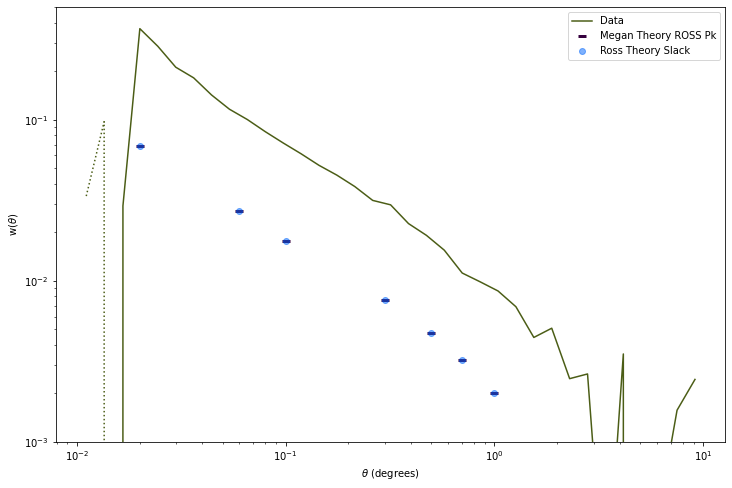

In [70]:
BOSS_Data = pd.read_csv('/Users/megantabbutt/CosmologyDataProducts/' 
                             + 'BOSS_AutoCorr_Plot_Results_df_9_28.csv', index_col=0)

r_BOSS = np.array(BOSS_Data['r_BOSS'])
xi_BOSS = np.array(BOSS_Data['xi_BOSS'])

plt.figure(figsize=(12, 8))

plt.plot(r_BOSS, xi_BOSS, color='#4b5d16', label="Data")
plt.plot(r_BOSS, -xi_BOSS, color='#4b5d16', ls=':')

plt.scatter(theta_array, gg_values_Try4, color='#36013f', marker='_', s=60, linewidths=3, label="Megan Theory ROSS Pk")
plt.scatter(Ross_theta, Ross_gg, color='#0165fc', marker='o', label="Ross Theory Slack", alpha=.5)

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'w($\theta$)')
plt.legend(loc='upper right')
plt.ylim([.001, .5])

plt.show()